In [1]:
import pandas as pd
import numpy as np

from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.metrics import roc_curve


base_dir = Path("/Data/taegun/prs_revision/0118_analysis/")

scenario = "prs_ehr_model"

df_cat_pe = pd.read_csv(base_dir / scenario / f"{scenario}_cat_parameter.csv")
df_lgb_pe = pd.read_csv(base_dir / scenario / f"{scenario}_lgb_parameter.csv")
df_log_pe = pd.read_csv(base_dir / scenario / f"{scenario}_log_parameter.csv")
df_rf_pe  = pd.read_csv(base_dir / scenario / f"{scenario}_rf_parameter.csv")
df_xgb_pe = pd.read_csv(base_dir / scenario / f"{scenario}_xgb_parameter.csv")

df_cat_pe["model"] = "catboost"
df_lgb_pe["model"] = "lightgbm"
df_log_pe["model"] = "logistic"
df_rf_pe["model"]  = "randomforest"
df_xgb_pe["model"] = "xgboost"

scenario = "ehr_model"

df_cat_e = pd.read_csv(base_dir / scenario / f"{scenario}_cat_parameter.csv")
df_lgb_e = pd.read_csv(base_dir / scenario / f"{scenario}_lgb_parameter.csv")
df_log_e = pd.read_csv(base_dir / scenario / f"{scenario}_log_parameter.csv")
df_rf_e  = pd.read_csv(base_dir / scenario / f"{scenario}_rf_parameter.csv")
df_xgb_e = pd.read_csv(base_dir / scenario / f"{scenario}_xgb_parameter.csv")

df_cat_e["model"] = "catboost"
df_lgb_e["model"] = "lightgbm"
df_log_e["model"] = "logistic"
df_rf_e["model"]  = "randomforest"
df_xgb_e["model"] = "xgboost"

scenario = "prs_model"

df_cat_p = pd.read_csv(base_dir / scenario / f"{scenario}_cat_parameter.csv")
df_lgb_p = pd.read_csv(base_dir / scenario / f"{scenario}_lgb_parameter.csv")
df_log_p = pd.read_csv(base_dir / scenario / f"{scenario}_log_parameter.csv")
df_rf_p  = pd.read_csv(base_dir / scenario / f"{scenario}_rf_parameter.csv")
df_xgb_p = pd.read_csv(base_dir / scenario / f"{scenario}_xgb_parameter.csv")

df_cat_p["model"] = "catboost"
df_lgb_p["model"] = "lightgbm"
df_log_p["model"] = "logistic"
df_rf_p["model"]  = "randomforest"
df_xgb_p["model"] = "xgboost"

POS_METRICS = ["AUC", "sensitivity", "specificity", "DOR", "LR+"]
NEG_METRICS = ["LR-"]

def select_best_lexicographic(df):
    best_rows = []

    for disease, sub_df in df.groupby("disease"):
        best = (
            sub_df
            .sort_values(
                by=["sensitivity", "specificity", "AUC"],
                ascending=[False, False, False]
            )
            .iloc[0]
        )
        best_rows.append(best)

    return pd.DataFrame(best_rows)


In [23]:
FILESss = {
    "/Data/taegun/prs_revision/data/df_diabet_match_pcr_final2.csv",
    "/Data/taegun/prs_revision/data/df_chf_match_pcr_final2.csv",
    "/Data/taegun/prs_revision/data/df_chd_match_pcr_final2.csv",
    "/Data/taegun/prs_revision/data/df_stroke_match_pcr_final2.csv",
    "/Data/taegun/prs_revision/data/df_af_match_pcr_final2.csv",
    "/Data/taegun/prs_revision/data/df_dem_match_pcr_final2.csv"
}
var_list=["AGE", "alcohol","BG","CALC_LDL","CPD", "CREAT", "DBP", "DLVH", "HDL", "HGT", "HIP", "SBP", "TRIG", "VENT_RT"]
for i in FILESss:
    print(i)
#    for j in var_list:
    dff = pd.read_csv(i)
    df_sub = dff.dropna()
#    print(j)
#        print(f"{df_sub[j].mean():.2f} ({df_sub[j].min():.2f}, {df_sub[j].max():.2f})")
    print(df_sub['Disease_status'].sum(), len(df_sub)-df_sub['Disease_status'].sum())

/Data/taegun/prs_revision/data/df_dem_match_pcr_final2.csv
323 5213
/Data/taegun/prs_revision/data/df_stroke_match_pcr_final2.csv
256 5681
/Data/taegun/prs_revision/data/df_chf_match_pcr_final2.csv
374 5569
/Data/taegun/prs_revision/data/df_af_match_pcr_final2.csv
658 5220
/Data/taegun/prs_revision/data/df_chd_match_pcr_final2.csv
461 5264
/Data/taegun/prs_revision/data/df_diabet_match_pcr_final2.csv
681 5386


In [2]:

from sklearn.metrics import roc_curve

def run_final_analysis(
    best_df,
    output_csv=None,
    return_roc=False,
    return_calibration=False,
    scenario="prs_ehr"
):
    results = []
    roc_data = []
    calibration_data = []   # ⭐ 추가

    for _, row in best_df.iterrows():

        disease = row["disease"]
        model_name = row["model"]
        sampling_method = row["sampling_method"]
        sampling_ratio = row["sampling_ratio"]

        X, y = load_data(disease, model_type=scenario)

        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            test_size=0.2,
            stratify=y,
            random_state=RANDOM_STATE
        )

        X_tr, y_tr = apply_sampling(
            X_train,
            y_train,
            sampling_method,
            sampling_ratio
        )

        class_weight = get_class_weight(
            y_tr,
            model_name=model_name,
            sampling_method=sampling_method
        )

        # model = MODEL_FACTORY[model_name].build(
        #     row,
        #     class_weight=class_weight
        # )
        # model.fit(X_tr, y_tr)

        # # ⭐ threshold 명시 (0.5 고정)
        # y_prob = model.predict_proba(X_test)[:, 1]
        # y_pred = (y_prob >= 0.5).astype(int)
        cols_to_scale = [c for c in X.columns if c not in ["AGE", "SEX", "DLVH"]]
        #cols_to_scale = [c for c in X.columns if c not in ["SEX", "CURRSMK"]]
        
        scaler = ColumnTransformer(
            transformers=[("scale", StandardScaler(), cols_to_scale)],
            remainder="passthrough"
        )
        
        base_model = MODEL_FACTORY[model_name].build(
            row,
            class_weight=class_weight
        )
        
        pipe = Pipeline([
            ("scaler", scaler),
            ("model", base_model)
        ])
        
        pipe.fit(X_tr, y_tr)
        
        y_prob = pipe.predict_proba(X_test)[:, 1]
        y_pred = (y_prob >= 0.5).astype(int)
        ####################################################
        metrics = evaluate_binary(y_test, y_pred, y_prob)

        results.append({
            "disease": disease,
            "model": model_name,
            "sampling_method": sampling_method,
            "sampling_ratio": sampling_ratio,
            **metrics
        })

        if return_roc:
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            roc_data.append({
                "disease": disease,
                "model": model_name,
                "fpr": fpr,
                "tpr": tpr,
                "auc": metrics["AUC"]
            })

        # ⭐ calibration용 raw data 저장
        if return_calibration:
            calibration_data.append({
                "disease": disease,
                "model": model_name,
                "y_true": y_test.values,
                "y_prob": y_prob
            })

    df_results = pd.DataFrame(results)

    if output_csv:
        df_results.to_csv(output_csv, index=False)

    if return_roc and return_calibration:
        return df_results, roc_data, calibration_data
    if return_roc:
        return df_results, roc_data
    if return_calibration:
        return df_results, calibration_data

    return df_results

In [3]:

# notebook setup
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parent
sys.path.insert(0, str(PROJECT_ROOT))

import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split

from model import MODEL_FACTORY
from sampling.sampler import apply_sampling, get_class_weight
from utils import load_data
from evaluate import evaluate_binary


# =========================
# Config
# =========================
BASE_DIR = Path("/Data/taegun/prs_revision/0115_analysis/")
RANDOM_STATE = 42

best_cat_pe = select_best_lexicographic(df_cat_pe)
best_lgb_pe = select_best_lexicographic(df_lgb_pe)
best_rf_pe  = select_best_lexicographic(df_rf_pe)
best_xgb_pe = select_best_lexicographic(df_xgb_pe)
best_log_pe = select_best_lexicographic(df_log_pe)

best_cat_e = select_best_lexicographic(df_cat_e)
best_lgb_e = select_best_lexicographic(df_lgb_e)
best_rf_e  = select_best_lexicographic(df_rf_e)
best_xgb_e = select_best_lexicographic(df_xgb_e)
best_log_e = select_best_lexicographic(df_log_e)

best_cat_p = select_best_lexicographic(df_cat_p)
best_lgb_p = select_best_lexicographic(df_lgb_p)
best_rf_p  = select_best_lexicographic(df_rf_p)
best_xgb_p = select_best_lexicographic(df_xgb_p)
best_log_p = select_best_lexicographic(df_log_p)

# result_xgb_pe = run_final_analysis(best_df=best_xgb,output_csv="final_xgb_pe_results.csv", scenario="prs_ehr")
# result_rf_pe = run_final_analysis(best_df=best_rf,output_csv="final_rf_pe_results.csv", scenario="prs_ehr")
# result_log_pe = run_final_analysis(best_df=best_log,output_csv="final_log_pe_results.csv", scenario="prs_ehr")
# result_lgb_pe = run_final_analysis(best_df=best_lgb,output_csv="final_lgb_pe_results.csv", scenario="prs_ehr")
# result_cat_pe = run_final_analysis(best_df=best_cat,output_csv="final_cat_pe_results.csv", scenario="prs_ehr")

# result_xgb_e = run_final_analysis(best_df=best_xgb,output_csv="final_xgb_e_results.csv", scenario="ehr")
# result_rf_e = run_final_analysis(best_df=best_rf,output_csv="final_rf_e_results.csv", scenario="ehr")
# result_log_e = run_final_analysis(best_df=best_log,output_csv="final_log_e_results.csv", scenario="ehr")
# result_lgb_e = run_final_analysis(best_df=best_lgb,output_csv="final_lgb_e_results.csv", scenario="ehr")
# result_cat_e = run_final_analysis(best_df=best_cat,output_csv="final_cat_e_results.csv", scenario="ehr")

# result_xgb_p = run_final_analysis(best_df=best_xgb,output_csv="final_xgb_pe_results.csv", scenario="prs")
# result_rf_p = run_final_analysis(best_df=best_rf,output_csv="final_rf_pe_results.csv", scenario="prs")
# result_log_p = run_final_analysis(best_df=best_log,output_csv="final_log_pe_results.csv", scenario="prs")
# result_lgb_p = run_final_analysis(best_df=best_lgb,output_csv="final_lgb_pe_results.csv", scenario="prs")
# result_cat_p = run_final_analysis(best_df=best_cat,output_csv="final_cat_pe_results.csv", scenario="prs")


In [15]:
best_rf_pe

,disease,sampling_method,sampling_ratio,AUC,sensitivity,specificity,DOR,LR+,LR-,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,model
3,af,undersample,1.0,0.824952,0.818182,0.710728,11.056291,2.828417,0.255820,entropy,10,sqrt,1,10,300,randomforest
11,chd,undersample,1.0,0.809576,0.728261,0.675522,5.579415,2.244406,0.402266,entropy,10,sqrt,1,2,500,randomforest
19,chf,undersample,1.0,0.885709,0.880000,0.736086,20.453513,3.334422,0.163024,entropy,5,sqrt,2,2,300,randomforest
26,dem,undersample,0.8,0.904986,0.846154,0.815916,24.377602,4.596554,0.188556,entropy,10,sqrt,1,2,100,randomforest
35,dia,undersample,1.0,0.965977,0.882353,0.940631,118.828097,14.862130,0.125073,entropy,10,sqrt,1,2,500,randomforest
43,stroke,undersample,1.0,0.747254,0.764706,0.621812,5.343604,2.022025,0.378401,entropy,3,sqrt,1,5,100,randomforest


In [5]:
result_all_pe, roc_all_pe, cal_all_pe = run_final_analysis(best_df=pd.concat([best_xgb_pe, best_rf_pe, best_log_pe, best_lgb_pe, best_cat_pe]),output_csv="/Data/taegun/prs_revision/0115_analysis/resulat_all_pe_0108.csv",return_roc=True,return_calibration=True, scenario="prs_ehr")
result_all_e, roc_all_e, cal_all_e = run_final_analysis(best_df=pd.concat([best_xgb_e, best_rf_e, best_log_e, best_lgb_e, best_cat_e]),output_csv="/Data/taegun/prs_revision/0115_analysis/resulat_all_e_0108.csv",return_roc=True,return_calibration=True, scenario="ehr")
result_all_p, roc_all_p, cal_all_p = run_final_analysis(best_df=pd.concat([best_xgb_p, best_rf_p, best_log_p, best_lgb_p, best_cat_p]),output_csv="/Data/taegun/prs_revision/0115_analysis/resulat_all_p_0108.csv",return_roc=True,return_calibration=True, scenario="prs")


/home/cblab/anaconda3/envs/prsml/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/cblab/anaconda3/envs/prsml/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/cblab/anaconda3/envs/prsml/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/cblab/anaconda3/envs/prsml/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/cblab/anaconda3/envs/prsml/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LG

In [16]:
roc_all_p

[{'disease': 'af',
  'model': 'xgboost',
  'fpr': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.05801773e-04,
         8.05801773e-04, 1.61160355e-03, 1.61160355e-03, 3.22320709e-03,
         3.22320709e-03, 4.83481064e-03, 4.83481064e-03, 5.64061241e-03,
         5.64061241e-03, 7.25221595e-03, 7.25221595e-03, 8.86381950e-03,
         8.86381950e-03, 1.04754230e-02, 1.04754230e-02, 1.20870266e-02,
         1.45044319e-02, 1.45044319e-02, 1.69218372e-02, 1.69218372e-02,
         1.85334408e-02, 1.85334408e-02, 1.93392425e-02, 1.93392425e-02,
         2.01450443e-02, 2.01450443e-02, 2.25624496e-02, 2.25624496e-02,
         2.33682514e-02, 2.49798550e-02, 2.65914585e-02, 2.65914585e-02,
         2.73972603e-02, 2.73972603e-02, 2.82030620e-02, 2.82030620e-02,
         2.98146656e-02, 2.98146656e-02, 3.06204674e-02, 3.38436745e-02,
         3.38436745e-02, 3.78726833e-02, 3.94842869e-02, 3.94842869e-02,
         4.10958904e-02, 4.10958904e-02, 4.19016922e-02, 4.35132957e-02,
   

In [6]:
def select_best_roc_by_disease(roc_list):
    best_dict = {}

    for r in roc_list:
        d = r["disease"]
        if d not in best_dict or r["auc"] > best_dict[d]["auc"]:
            best_dict[d] = r

    return list(best_dict.values())
def add_source(roc_list, source_name):
    return [
        {**r, "source": source_name}
        for r in roc_list
    ]
best_roc_pe = select_best_roc_by_disease(roc_all_pe)
best_roc_p  = select_best_roc_by_disease(roc_all_p)
best_roc_e  = select_best_roc_by_disease(roc_all_e)

best_roc_pe = add_source(best_roc_pe, "PE")
best_roc_p  = add_source(best_roc_p,  "P")
best_roc_e  = add_source(best_roc_e,  "E")

best_roc_all = best_roc_pe + best_roc_p + best_roc_e

In [18]:
import numpy as np
import scipy.stats as stats
from itertools import combinations

def compute_midrank(x):
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5 * (i + j - 1) + 1
        i = j
    T2 = np.empty(N)
    T2[J] = T
    return T2
    
def delong_roc_variance(y_true, y_scores):
    y_true = np.asarray(y_true)
    y_scores = np.asarray(y_scores)

    pos = y_scores[y_true == 1]
    neg = y_scores[y_true == 0]

    m, n = len(pos), len(neg)

    tx = compute_midrank(np.concatenate([pos, neg]))[:m]
    ty = compute_midrank(np.concatenate([pos, neg]))[m:]

    auc = (tx.sum() - m * (m + 1) / 2) / (m * n)

    v01 = (tx - (m + 1) / 2) / n
    v10 = (ty - (n + 1) / 2) / m

    sx = np.var(v01, ddof=1)
    sy = np.var(v10, ddof=1)

    return auc, sx / m + sy / n


def delong_test(y_true, scores1, scores2):
    auc1, var1 = delong_roc_variance(y_true, scores1)
    auc2, var2 = delong_roc_variance(y_true, scores2)

    diff = auc1 - auc2
    var = var1 + var2
    z = diff / np.sqrt(var)
    p = 2 * stats.norm.sf(abs(z))

    return {
        "auc1": auc1,
        "auc2": auc2,
        "auc_diff": diff,
        "z": z,
        "p_value": p
    }


In [20]:
delong_results = []
for disease in set(d["disease"] for d in cal_all_pe):
    subset = [d for d in cal_all_pe if d["disease"] == disease]

    for a, b in combinations(subset, 2):
        res = delong_test(
            a["y_true"],
            a["y_prob"],
            b["y_prob"]
        )

        delong_results.append({
            "disease": disease,
            "model_1": a["model"],
            "model_2": b["model"],
            **res
        })

In [21]:
delong_results

[{'disease': 'chd',
  'model_1': 'xgboost',
  'model_2': 'randomforest',
  'auc1': 0.8136601765530896,
  'auc2': 0.8095763550862141,
  'auc_diff': 0.004083821466875581,
  'z': 0.026136444160524252,
  'p_value': 0.9791485087469916},
 {'disease': 'chd',
  'model_1': 'xgboost',
  'model_2': 'logistic',
  'auc1': 0.8136601765530896,
  'auc2': 0.8180740037950665,
  'auc_diff': -0.004413827241976809,
  'z': -0.028284732027446077,
  'p_value': 0.9774350578059524},
 {'disease': 'chd',
  'model_1': 'xgboost',
  'model_2': 'lightgbm',
  'auc1': 0.8136601765530896,
  'auc2': 0.8174243049253362,
  'auc_diff': -0.0037641283722466,
  'z': -0.02411934568679672,
  'p_value': 0.9807574121841934},
 {'disease': 'chd',
  'model_1': 'xgboost',
  'model_2': 'catboost',
  'auc1': 0.8136601765530896,
  'auc2': 0.8128970381981685,
  'auc_diff': 0.0007631383549211446,
  'z': 0.004886558998509235,
  'p_value': 0.9961011055362419},
 {'disease': 'chd',
  'model_1': 'randomforest',
  'model_2': 'logistic',
  'auc1'

In [62]:
# import matplotlib.pyplot as plt
# import os

# def plot_roc_by_disease(
#     roc_data,
#     disease,
#     disease_name,
#     save=False,
#     save_dir="/Data/taegun/prs_revision/0103_analysis",
#     scenario="PRS+EHR",
#     dpi=300
# ):

#     plt.figure(figsize=(5, 5))

#     for r in roc_data:
#         if r["disease"] == disease:
#             plt.plot(
#                 r["fpr"],
#                 r["tpr"],
#                 label=f'{r["model"]} (AUC={r["auc"]:.3f})'
#             )

#     plt.plot([0, 1], [0, 1], linestyle="--")
#     plt.xlabel("False Positive Rate")
#     plt.ylabel("True Positive Rate")
#     plt.title(f"ROC Curve – {disease_name}")
#     plt.legend()
#     plt.tight_layout()

#     if save:
#         os.makedirs(save_dir, exist_ok=True)
#         plt.savefig(
#             f"{save_dir}/roc_{scenario}_{disease}.png",
#             dpi=dpi,
#             bbox_inches="tight"
#         )

#     plt.show()


In [40]:
# import matplotlib.pyplot as plt
# import os

# SOURCE_MAP = {
#     "PE": "PRS+EHR",
#     "P": "PRS",
#     "E": "EHR"
# }

# def plot_roc_by_disease(
#     roc_data,
#     disease,
#     disease_name,
#     save=False,
#     save_dir="/Data/taegun/prs_revision/0117_analysis",
#     dpi=300
# ):

#     plt.figure(figsize=(5, 5))

#     for r in roc_data:
#         if r["disease"] == disease:
#             source_label = SOURCE_MAP.get(r.get("source"), r.get("source", ""))
#             plt.plot(
#                 r["fpr"],
#                 r["tpr"],
#                 label=f'{source_label} ({r["model"]}, AUC={r["auc"]:.3f})'
#             )
# #                label=f'{r["model"]} ({source_label}, AUC={r["auc"]:.3f})'

#     plt.plot([0, 1], [0, 1], linestyle="--")
#     plt.xlabel("False Positive Rate")
#     plt.ylabel("True Positive Rate")
#     plt.title(f"ROC Curve – {disease_name}")
#     plt.legend(fontsize=10)
#     plt.tight_layout()

#     if save:
#         os.makedirs(save_dir, exist_ok=True)
#         plt.savefig(
#             f"{save_dir}/roc_{disease}.png",
#             dpi=dpi,
#             bbox_inches="tight"
#         )

#     plt.show()


In [44]:
import matplotlib.pyplot as plt
import os

SOURCE_MAP = {
    "PE": "PRS+EHR",
    "P": "PRS",
    "E": "EHR"
}

MODEL_MAP = {
    "randomforest": "random forest",
    "catboost": "CatBoost",
    "xgboost": "XGBoost",
    "lightgbm": "LightGBM",
    "logistic": "logistic regression"
}

def plot_roc_by_disease(
    roc_data,
    disease,
    disease_name,
    save=False,
    save_dir="/Data/taegun/prs_revision/0117_analysis",
    dpi=300
):

    plt.figure(figsize=(5, 5))

    for r in roc_data:
        if r["disease"] == disease:
            source_label = SOURCE_MAP.get(r.get("source"), r.get("source", ""))
            model_label = MODEL_MAP.get(r.get("model", "").lower(), r.get("model", ""))
            plt.plot(
                r["fpr"],
                r["tpr"],
                label=f'{source_label} ({model_label}, AUC={r["auc"]:.3f})'
            )

    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve – {disease_name}")
    plt.legend(fontsize=9)
    plt.tight_layout()

    if save:
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(
            f"{save_dir}/roc_{disease}.png",
            dpi=dpi,
            bbox_inches="tight"
        )

    plt.show()

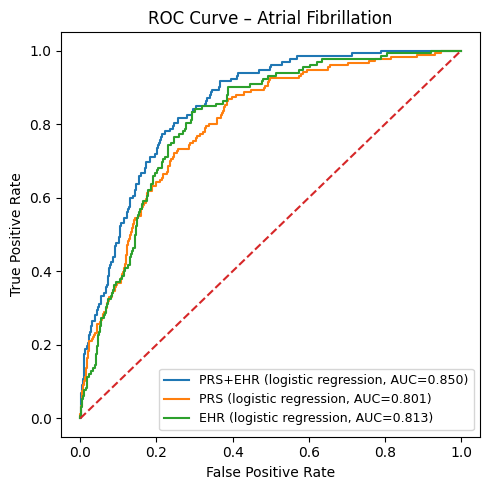

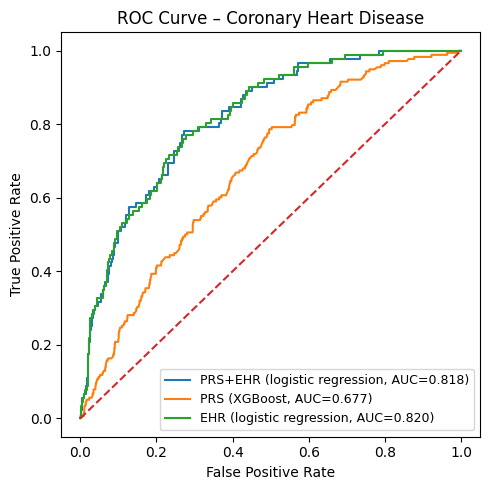

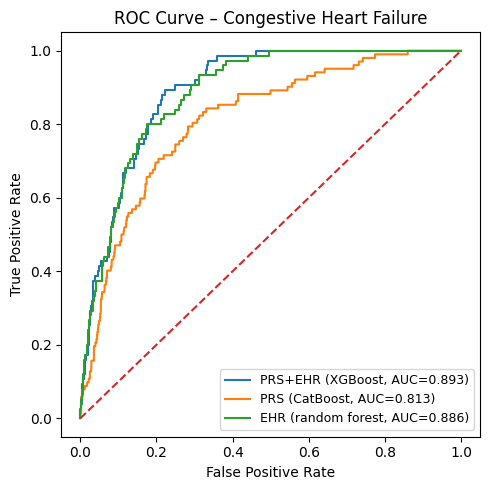

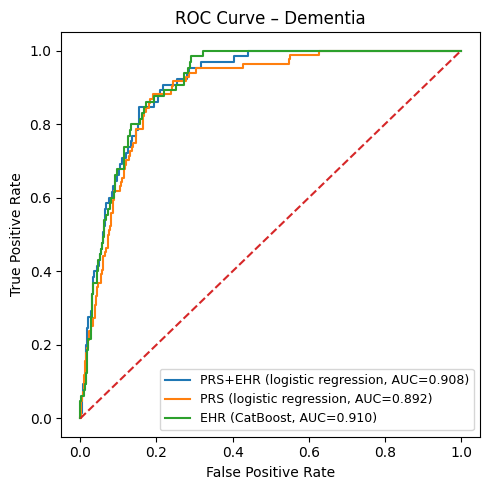

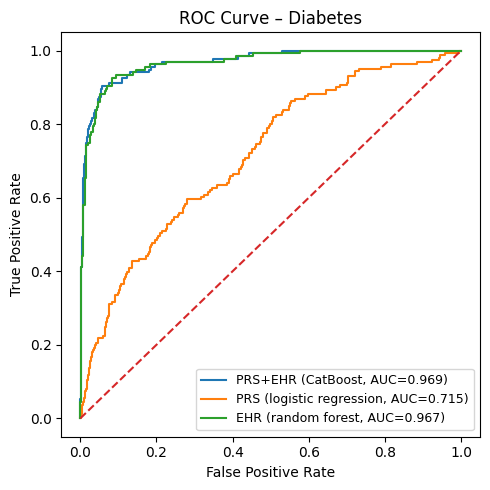

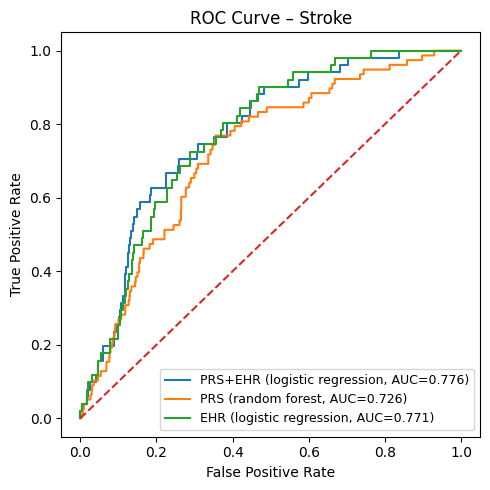

In [45]:
# disease_list = ["dia", "chf", "chd", "stroke", "af", "dem"]
# disease_name = ["Atrial Fibrillation", "Coronary Heart Disease","Congestive Heart Failure", "Dementia","Diabetes", "Stroke"]

# for disease in disease_list:
#     plot_roc_by_disease(best_roc_all, disease=disease, save=True, save_dir="1215_result_plot_withoutBG")


disease_map = {
    "af": "Atrial Fibrillation",
    "chd": "Coronary Heart Disease",
    "chf": "Congestive Heart Failure",
    "dem": "Dementia",
    "dia": "Diabetes",
    "stroke": "Stroke"
}

for disease, disease_name in disease_map.items():
    plot_roc_by_disease(
        best_roc_all,
        disease=disease,
        disease_name=disease_name,
        save=True       
    )

In [21]:
# result_all_pe, roc_all_pe = run_final_analysis(best_df=pd.concat([best_xgb_pe, best_rf_pe, best_log_pe, best_lgb_pe, best_cat_pe]),return_roc=True, scenario="prs_ehr")
# result_all_e, roc_all_e = run_final_analysis(best_df=pd.concat([best_xgb_e, best_rf_e, best_log_e, best_lgb_e, best_cat_e]),return_roc=True, scenario="ehr")
# result_all_p, roc_all_p = run_final_analysis(best_df=pd.concat([best_xgb_p, best_rf_p, best_log_p, best_lgb_p, best_cat_p]),return_roc=True, scenario="prs")


all_results = []

for seed in range(100):
    RANDOM_STATE = seed

    df_res = run_final_analysis(
        best_df=pd.concat([best_xgb_pe, best_rf_pe, best_log_pe, best_lgb_pe, best_cat_pe]),
        return_roc=False,
        scenario="prs_ehr"
    )

    df_res["seed"] = seed
    all_results.append(df_res)

df_all = pd.concat(all_results, ignore_index=True)

In [20]:
df_all

NameError: name 'df_all' is not defined

In [6]:
def summarize_with_ci(df, metric):
    return pd.Series({
        "mean": df[metric].mean(),
        "ci_lower": df[metric].quantile(0.025),
        "ci_upper": df[metric].quantile(0.975),
    })


In [ ]:
summary = (
    df_all
    .groupby(["disease", "model"])
    .apply(lambda x: summarize_with_ci(x, "AUC"))
)
summary

In [6]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np

def plot_calibration(calib_data, disease, model, n_bins=10):

    ys = []
    ps = []

    for d in calib_data:
        if d["disease"] == disease and d["model"] == model:
            ys.append(d["y_true"])
            ps.append(d["y_prob"])

    y_true = np.concatenate(ys)
    y_prob = np.concatenate(ps)

    prob_true, prob_pred = calibration_curve(
        y_true, y_prob, n_bins=n_bins, strategy="quantile"
    )

    plt.figure(figsize=(4,4))
    plt.plot(prob_pred, prob_true, marker="o", label=model)
    plt.plot([0,1], [0,1], linestyle="--", color="gray")
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Observed proportion")
    plt.title(f"Calibration – {disease}")
    plt.legend()
    plt.tight_layout()
    plt.show()


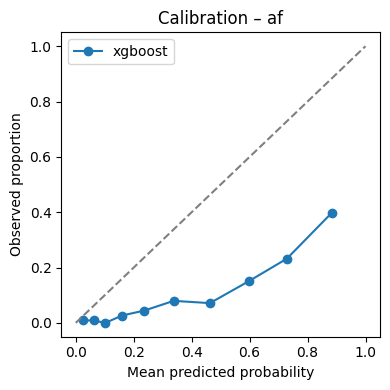

In [7]:
plot_calibration(cal_all_pe, "af", "xgboost")

In [21]:
# import shap
# import matplotlib.pyplot as plt

# def plot_shap_summary(
#     model,
#     X,
#     max_display=15,
#     save_path=None,
#     dpi=300
# ):
#     explainer = shap.TreeExplainer(model)
#     shap_values = explainer.shap_values(X)

#     # binary classification
#     if isinstance(shap_values, list):
#         shap_values = shap_values[1]

#     plt.figure(figsize=(8, 6))

#     shap.summary_plot(
#         shap_values,
#         X,
#         max_display=max_display,
#         show=False
#     )

#     if save_path is not None:
#         plt.savefig(save_path, dpi=dpi, bbox_inches="tight")

#     plt.close()


# def plot_shap_summary_logistic(
#     model,
#     X,
#     max_display=15,
#     save_path=None,
#     dpi=300
# ):
#     explainer = shap.LinearExplainer(model, X)
#     shap_values = explainer.shap_values(X)

#     plt.figure(figsize=(8, 6))

#     shap.summary_plot(
#         shap_values,
#         X,
#         max_display=max_display,
#         show=False
#     )

#     if save_path:
#         plt.savefig(save_path, dpi=dpi, bbox_inches="tight")

#     plt.close()

In [12]:
import shap
import matplotlib.pyplot as plt

def plot_shap_summary(
    pipe,
    X,
    max_display=15,
    save_path=None,
    trait=None,
    dpi=300
):

    scaler = pipe.named_steps["scaler"]
    model = pipe.named_steps["model"]

    X_scaled = scaler.transform(X)

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_scaled)

    # binary classification
    if isinstance(shap_values, list):
        shap_values = shap_values[1]

    plt.figure(figsize=(8, 6))
    shap.summary_plot(
        shap_values,
        X_scaled,
        feature_names=scaler.get_feature_names_out(),
        max_display=max_display,
        show=False
    )
    plt.title(trait, fontsize=14, pad=12)  # 🔥 추가
    
    if save_path is not None:
        plt.savefig(save_path, dpi=dpi, bbox_inches="tight")

    plt.close()

def plot_shap_summary_logistic(
    pipe,
    X,
    max_display=15,
    save_path=None,
    trait=None,
    dpi=300
):
    scaler = pipe.named_steps["scaler"]
    model = pipe.named_steps["model"]

    # background: X에서 일부만 사용 (기존 스타일 최대한 유지)
    X_bg = X.sample(min(200, len(X)), random_state=42)

    X_bg_scaled = scaler.transform(X_bg)
    X_scaled = scaler.transform(X)

    explainer = shap.LinearExplainer(
        model,
        X_bg_scaled,
        feature_names=scaler.get_feature_names_out()
    )

    shap_values = explainer.shap_values(X_scaled)

    plt.figure(figsize=(8, 6))
    shap.summary_plot(
        shap_values,
        X_scaled,
        feature_names=scaler.get_feature_names_out(),
        max_display=max_display,
        show=False
    )
    plt.title(trait, fontsize=14, pad=12)  # 🔥 추가
    
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches="tight")

    plt.close()

In [14]:
# best_cat_pe = select_best_lexicographic(df_cat_pe)
# best_lgb_pe = select_best_lexicographic(df_lgb_pe)
# best_rf_pe  = select_best_lexicographic(df_rf_pe)
# best_xgb_pe = select_best_lexicographic(df_xgb_pe)
# best_log_pe = select_best_lexicographic(df_log_pe)

    # "xgboost": XGBModel(),
    # "lightgbm": LGBModel(),
    # "catboost": CatModel(),
    # "randomforest": RFModel(),
    # "logistic": LogisticModel()

row = best_xgb_pe.query("disease == 'chf'").iloc[0]  ### ###
X, y = load_data("chf", model_type="prs_ehr") ###

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# model = MODEL_FACTORY["logistic"].build(row)
# model.fit(X_train, y_train)


cols_to_scale = [c for c in X.columns if c not in ["AGE", "SEX", "DLVH"]]

scaler = ColumnTransformer(
    transformers=[("scale", StandardScaler(), cols_to_scale)],
    remainder="passthrough",
    verbose_feature_names_out=False
)
scaler.set_output(transform="pandas")

base_model = MODEL_FACTORY["xgboost"].build(row) ### 

pipe = Pipeline([
    ("scaler", scaler),
    ("model", base_model)
])

pipe.fit(X_train, y_train)
#Atrial Fibrillation 
#Coronary Heart Disease
#Congestive Heart Failure
#Dementia
#Diabetes
#Stroke

plot_shap_summary(pipe, X_test, save_path="/Data/taegun/prs_revision/0115_analysis/prs_ehr_chf_xgboost_0115.png", trait="Congestive Heart Failure") ###
#plot_shap_summary_logistic(pipe, X_test, save_path="/Data/taegun/prs_revision/0115_analysis/prs_ehr_chd_logistic_0115.png", trait="Coronary Heart Disease") ###

9.447794963463453e-07

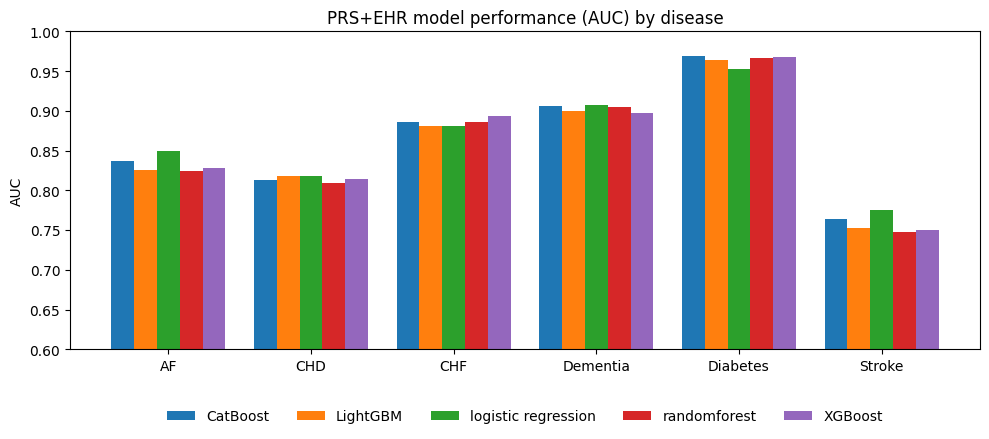

In [32]:
df = result_all_pe.copy()

# 질병 순서 고정 (논문용 중요)
disease_order = ["af", "chd", "chf", "dem", "dia", "stroke"]
df["disease"] = pd.Categorical(df["disease"], categories=disease_order, ordered=True)
disease_labels = ["AF", "CHD", 
                  "CHF", "Dementia", 
                  "Diabetes", "Stroke"]
model_name_map = {
    "catboost": "CatBoost",
    "lightgbm": "LightGBM",
    "logistic": "logistic regression",
    "xgboost": "XGBoost",
    "rf": "random forest"
}
# pivot: disease × model → AUC
auc_pivot = df.pivot(
    index="disease",
    columns="model",
    values="AUC"
).loc[disease_order]

models = auc_pivot.columns.tolist()
n_models = len(models)
n_diseases = len(auc_pivot.index)

x = np.arange(n_diseases)
width = 0.8 / n_models   # bar 폭 자동 조절

plt.figure(figsize=(10, 5))

for i, model in enumerate(models):
    plt.bar(
        x + i * width,
        auc_pivot[model],
        width=width,
        label=model_name_map.get(model, model)  # 이름 변경
    )

plt.xticks(x + width * (n_models - 1) / 2, disease_labels)
plt.ylabel("AUC")
plt.ylim(0.6, 1.0)
plt.title("PRS+EHR model performance (AUC) by disease")

plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=len(models),
    frameon=False
)

plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.show()

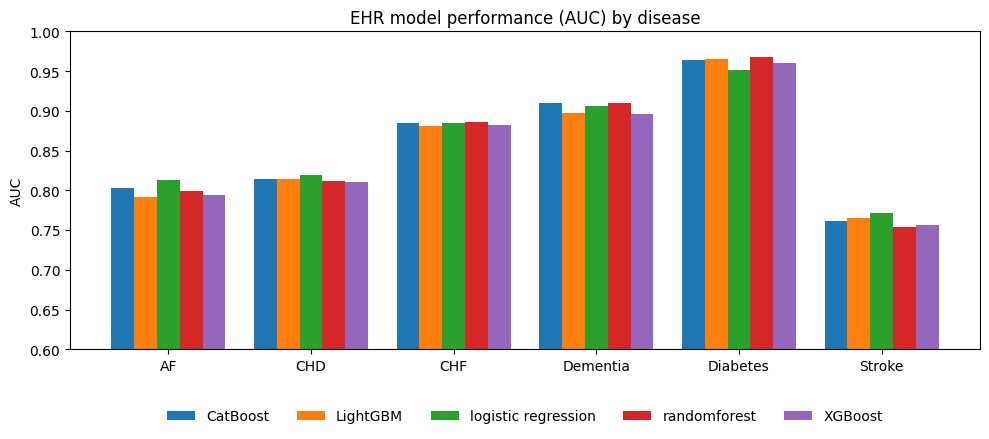

In [34]:
df = result_all_e.copy()

# 질병 순서 고정 (논문용 중요)
disease_order = ["af", "chd", "chf", "dem", "dia", "stroke"]
disease_labels = ["AF", "CHD", 
                  "CHF", "Dementia", 
                  "Diabetes", "Stroke"]
model_name_map = {
    "catboost": "CatBoost",
    "lightgbm": "LightGBM",
    "logistic": "logistic regression",
    "xgboost": "XGBoost",
    "rf": "random forest"
}
df["disease"] = pd.Categorical(df["disease"], categories=disease_order, ordered=True)

# pivot: disease × model → AUC
auc_pivot = df.pivot(
    index="disease",
    columns="model",
    values="AUC"
).loc[disease_order]

models = auc_pivot.columns.tolist()
n_models = len(models)
n_diseases = len(auc_pivot.index)

x = np.arange(n_diseases)
width = 0.8 / n_models   # bar 폭 자동 조절

plt.figure(figsize=(10, 5))

for i, model in enumerate(models):
    plt.bar(
        x + i * width,
        auc_pivot[model],
        width=width,
        label=model_name_map.get(model, model)
    )

plt.xticks(x + width * (n_models - 1) / 2, disease_labels)
plt.ylabel("AUC")
plt.ylim(0.6, 1.0)
plt.title("EHR model performance (AUC) by disease")

plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=len(models),
    frameon=False
)

plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.show()

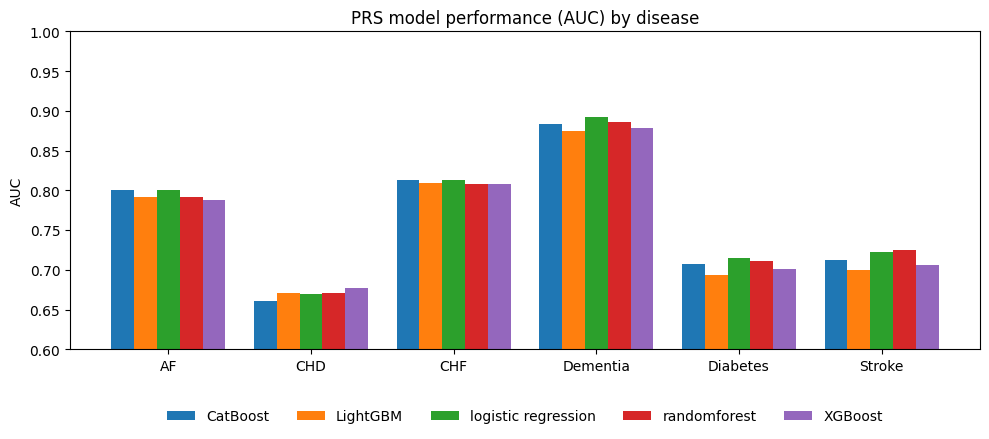

In [33]:
df = result_all_p.copy()

# 질병 순서 고정 (논문용 중요)
disease_order = ["af", "chd", "chf", "dem", "dia", "stroke"]
df["disease"] = pd.Categorical(df["disease"], categories=disease_order, ordered=True)
disease_labels = ["AF", "CHD", 
                  "CHF", "Dementia", 
                  "Diabetes", "Stroke"]
model_name_map = {
    "catboost": "CatBoost",
    "lightgbm": "LightGBM",
    "logistic": "logistic regression",
    "xgboost": "XGBoost",
    "rf": "random forest"
}
# pivot: disease × model → AUC
auc_pivot = df.pivot(
    index="disease",
    columns="model",
    values="AUC"
).loc[disease_order]

models = auc_pivot.columns.tolist()
n_models = len(models)
n_diseases = len(auc_pivot.index)

x = np.arange(n_diseases)
width = 0.8 / n_models   # bar 폭 자동 조절

plt.figure(figsize=(10, 5))

for i, model in enumerate(models):
    plt.bar(
        x + i * width,
        auc_pivot[model],
        width=width,
        label=model_name_map.get(model, model)
    )

plt.xticks(x + width * (n_models - 1) / 2, disease_labels)
plt.ylabel("AUC")
plt.ylim(0.6, 1.0)
plt.title("PRS model performance (AUC) by disease")

plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=len(models),
    frameon=False
)

plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.show()

In [24]:
import sklearn
import xgboost
import lightgbm
import catboost
import imblearn

print("scikit-learn:", sklearn.__version__)
print("xgboost:", xgboost.__version__)
print("lightgbm:", lightgbm.__version__)
print("catboost:", catboost.__version__)
print("imbalanced-learn:", imblearn.__version__)
print("sharp:", shap.__version__)


scikit-learn: 1.7.2
xgboost: 2.0.3
lightgbm: 4.6.0
catboost: 1.2.8
imbalanced-learn: 0.14.0
sharp: 0.44.1
